<a href="https://colab.research.google.com/github/sayyed-uoft/fullstackai/blob/main/11_Implementing_MLPs_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strata.ai - Artificial Intelligence Certificate 

# Module 3: Practical Deep Learning

# Implementing MLPs with Keras
**Text Book:** Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow, Second Edition, Aurélien Géron

Source: https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

# Setup

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Deep Learning Frameworks

- A **deep learning framework** is an interface, library or a tool which allows us to build deep learning models more easily and quickly, without getting into the details of underlying algorithms. 
- They provide a clear and concise way for defining models using a collection of pre-built and optimized components.
- The most common frameworks are:
    - Tensorflow 2 (Google)
    - Keras 
    - PyTorch (Facebook)
    - MXNet (Apache)
    - Caffe (Berkeley)
    - DeepLearning4J

# Tensorflow 2

- **TensorFlow 2** is an end-to-end, open-source machine learning platform. It combines four key abilities:
    - Efficiently executing low-level tensor operations on CPU, GPU, or TPU.
    - Computing the gradient of arbitrary differentiable expressions.
    - Scaling computation to many devices (e.g. the Summit supercomputer at Oak Ridge National Lab, which spans 27,000 GPUs).
    - Exporting programs ("graphs") to external runtimes such as servers, browsers, mobile and embedded devices.

# Keras

- **Keras** is the high-level API of TensorFlow 2: an approachable, highly-productive interface for solving machine learning problems, with a focus on modern deep learning. It provides essential abstractions and building blocks for developing and shipping machine learning solutions with high iteration velocity.
- Keras empowers engineers and researchers to take full advantage of the scalability and cross-platform capabilities of TensorFlow 2: you can run Keras on TPU or on large clusters of GPUs, and you can export your Keras models to run in the browser or on a mobile device.
- Keras documentation (or specification) is available at https://keras.io.


# Working with Keras

- The core data structures of Keras are **layers** and **models**. 
- The simplest type of model is the **Sequential model**, a linear stack of layers. 
- For more complex architectures, you should use the **Keras functional API**, which allows to build arbitrary graphs of layers, or write models entirely from scratch via subclasssing.
- Let's learn working with Keras with a real example:

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
tf.__version__

'2.5.0'

In [7]:
keras.__version__

'2.5.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [8]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


The training set contains 60,000 grayscale images, each 28x28 pixels:

In [9]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [10]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [11]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

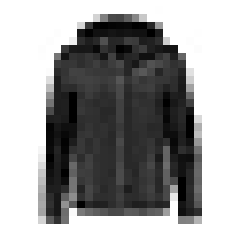

In [12]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [13]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [14]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [15]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [16]:
X_valid.shape

(5000, 28, 28)

In [17]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


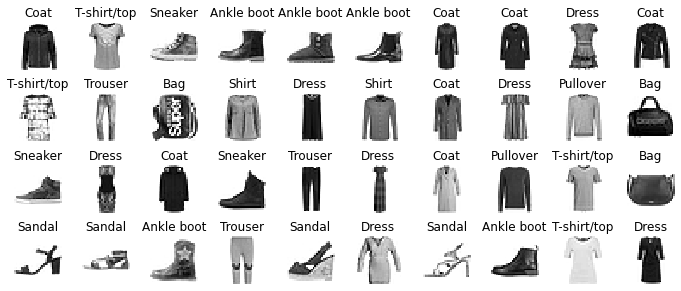

In [18]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

Let's create a Sequential model and add three dense (fully connected layer). We first need to flatten the image to a vector.

In [19]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

Let’s go through this code line by line:

- The first line creates a Sequential model. This is the simplest kind of Keras model, for neural networks that are just composed of a single stack of layers, connected sequentially. This is called the sequential API.
- Next, we build the first layer and add it to the model. It is a Flatten layer whose role is simply to convert each input image into a 1D array: if it receives input data X, it computes X.reshape(-1, 1). This layer does not have any parameters, it is just there to do some simple preprocessing. Since it is the first layer in the model, you should specify the input_shape: this does not include the batch size, only the shape of the instances. Alternatively, you could add a keras.layers.InputLayer as the first layer, setting shape=[28,28].
- Next we add a Dense hidden layer with 300 neurons. It will use the ReLU activa‐ tion function. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron). When it receives some input data, it computes.
- Next we add a second Dense hidden layer with 100 neurons, also using the ReLU activation function.
- Finally, we add a Dense output layer with 10 neurons (one per class), using the softmax activation function (because the classes are exclusive).

Let's reset all state generated by Keras to create the model again. Alos, set some random seeds.

In [20]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Instead of adding the layers one by one as we just did, you can pass a list of layers when creating the Sequential model:

In [21]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

The model’s summary() method displays all the model’s layers1, including each layer’s name (which is automatically generated unless you set it when creating the layer), its output shape (None means the batch size can be anything), and its number of parameters. The summary ends with the total number of parameters, including trainable and non-trainable parameters. Here we only have trainable parameters.

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Let's plot the model to visualize it:

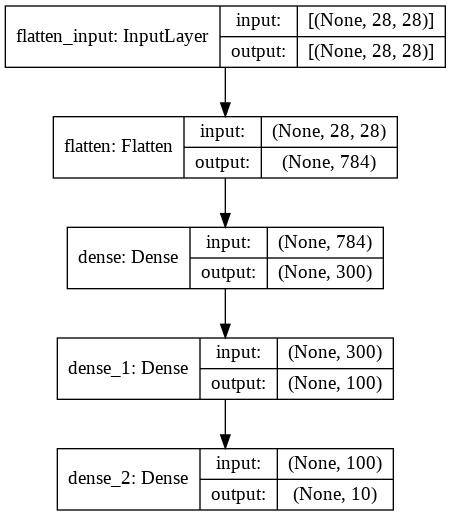

In [23]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

## Note: 
The Dense layers often have a lot of parameters. For example, the first hidden layer has 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters! This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data.

You can easily get a model’s list of layers, to fetch a layer by its index, or you can fetch it by name:

In [24]:
model.layers

In [25]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [26]:
model.get_layer(hidden1.name) is hidden1

True

All the parameters of a layer can be accessed using its get_weights() and set_weights() method. For a Dense layer, this includes both the connection weights and the bias terms:

In [27]:
weights, biases = hidden1.get_weights()

In [28]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [29]:
weights.shape

(784, 300)

In [30]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [31]:
biases.shape

(300,)

Notice that the Dense layer initialized the connection weights randomly (which is needed to break symmetry, as we discussed earlier), and the biases were just initial‐ ized to zeros, which is fine. If you ever want to use a different initialization method, you can set kernel_initializer (kernel is another name for the matrix of connection weights) or bias_initializer when creating the layer.

# Compiling the Model

After a model is created, you must call its compile() method to specify the loss function and the optimizer to use. Optionally, you can also specify a list of extra metrics to compute during training and evaluation:

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

- We use the "sparse_categorical_crossen tropy" loss because we have sparse labels (i.e., for each instance there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. If instead we had one target probability per class for each instance (such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the "categorical_crossentropy" loss instead. If we were doing binary classi‐ fication (with one or more binary labels), then we would use the "sigmoid" (i.e., logistic) activation function in the output layer instead of the "softmax" activation function, and we would use the "binary_crossentropy" loss.
- Regarding the optimizer, "sgd" simply means that we will train the model using simple Stochastic Gradient Descent. In other words, Keras will perform the backpropagation algorithm described earlier (i.e., reverse-mode autodiff + Gradient Descent). 
- Since this is a classifier, it’s useful to measure its "accuracy" during training and evaluation.

# Training the Model

Now the model is ready to be trained. For this we simply need to call its fit() method. We pass it the input features (X_train) and the target classes (y_train), as well as the number of epochs to train (or else it would default to just 1, which would definitely not be enough to converge to a good solution). We also pass a validation set (this is optional): Keras will measure the loss and the extra metrics on this set at the end of each epoch, which is very useful to see how well the model really performs: if the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a data mis‐ match between the training set and the validation set):

In [33]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.7237 - accuracy: 0.7643 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4842 - accuracy: 0.8318 - val_loss: 0.4353 - val_accuracy: 0.8526
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4391 - accuracy: 0.8457 - val_loss: 0.5333 - val_accuracy: 0.7988
Epoch 4/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4123 - accuracy: 0.8564 - val_loss: 0.3916 - val_accuracy: 0.8650
Epoch 5/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3939 - accuracy: 0.8616 - val_loss: 0.3741 - val_accuracy: 0.8698
Epoch 6/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3751 - accuracy: 0.8678 - val_loss: 0.3706 - val_accuracy: 0.8726
Epoch 7/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3630 - accuracy: 0.8715 - val_loss: 0.3621 - val_accuracy:

The neural network is trained. At each epoch during training, Keras displays the number of instances processed so far (along with a progress bar), the mean training time per sample, the loss and accuracy (or any other extra metrics you asked for), both on the training set and the validation set. You can see that the training loss went down, which is a good sign, and the validation accuracy reached to more than 89% after 30 epochs, not too far from the training accuracy, so there does not seem to be much overfitting going on.

The fit() method returns a History object containing the training parameters (his tory.params), the list of epochs it went through (history.epoch), and most impor‐ tantly a dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set (if any). If you create a Pandas DataFrame using this dictionary and call its plot() method, you get the learning curves.

In [34]:
history.params

{'epochs': 30, 'steps': 1719, 'verbose': 1}

In [35]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


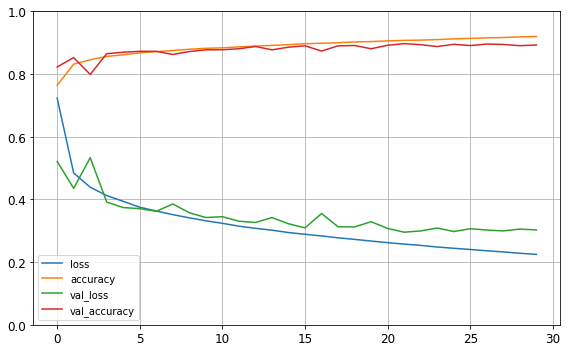

In [37]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

You can see that both the training and validation accuracy steadily increase during training, while the training and validation loss decrease. Good! Moreover, the valida‐ tion curves are quite close to the training curves, which means that there is not too much overfitting.

## Note:

If you are not satisfied with the performance of your model, you should go back and tune the model’s hyperparameters, for example the number of layers, the number of neurons per layer, the types of activation functions we use for each hidden layer, the number of training epochs, the batch size (it can be set in the fit() method using the batch_size argument, which defaults to 32).

# Evaluating the Model

Once you are satisfied with your model’s validation accuracy, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production. You can easily do this using the evalu ate() method (it also supports several other arguments, such as batch_size or sam ple_weight, please check the documentation for more details):

In [38]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3366 - accuracy: 0.8820


[0.3366333842277527, 0.8820000290870667]

Let's take a moment and analyze the result.

# Using the Model to Make Predictions

Next, we can use the model’s predict() method to make predictions on new instan‐ ces. Since we don’t have actual new instances, we will just use the first 3 instances of the test set:

In [39]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

For each instance the model estimates one probability per class, from class 0 to class 9. For example, for the first sample it is 96% sure it is class 9. 

If you only care about the class with the highest estimated probability (even if that probability is quite low) then you can use the `np.argmax(model.predict(X_new), axis=-1)` method instead:


In [40]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1])

In [41]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [42]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Let's plot the predictions:

Saving figure fashion_mnist_images_plot


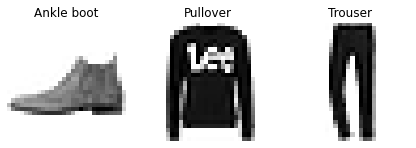

In [43]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()